Trades Data:                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         

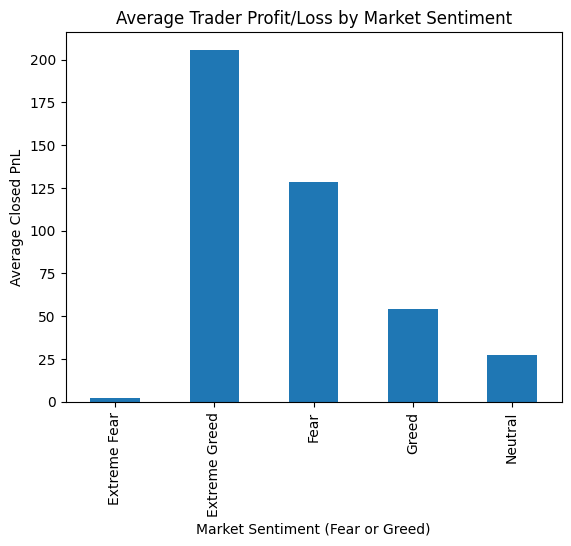

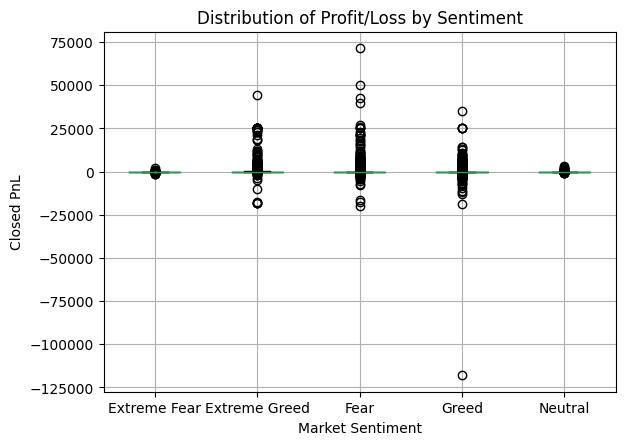

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

trades = pd.read_csv(r"C:\Users\DELL\Downloads\historical_data.csv")
sentiment = pd.read_csv(r"C:\Users\DELL\Downloads\fear_greed_index.csv")

print("Trades Data:", trades.head())
print("\nSentiment Data:", sentiment.head())

trades['time'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
sentiment['Date'] = pd.to_datetime(sentiment['date'], errors='coerce')

trades['trade_date'] = trades['time'].dt.date
sentiment['date'] = sentiment['Date'].dt.date

merged = pd.merge(trades, sentiment[['date', 'classification']],
                  left_on='trade_date', right_on='date', how='left')

print("\nMerged Data (first few rows):")
print(merged[['trade_date', 'Account', 'Coin', 'Closed PnL', 'classification']].head())

merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')

summary = merged.groupby('classification')['Closed PnL'].agg(
    ['count', 'mean', 'median', 'min', 'max']
).reset_index()

print("\nTrader performance by market sentiment:",summary)

summary.plot(x='classification', y='mean', kind='bar', legend=False)
plt.title('Average Trader Profit/Loss by Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment (Fear or Greed)')
plt.show()

merged.boxplot(column='Closed PnL', by='classification')
plt.title('Distribution of Profit/Loss by Sentiment')
plt.suptitle('')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()


Same-day correlation: 0.0119
1-day lead/lag correlation: 0.0119
2-day lead/lag correlation: 0.0119

PnL percentiles by sentiment bucket:
                   5th_pct  25th_pct  50th_pct   75th_pct    95th_pct
sentiment_bucket                                                     
Extreme Fear     -0.230868       0.0   0.00000   0.298102   17.661397
Extreme Greed    -0.667620       0.0   0.96048  30.153710  565.801908
Fear             -2.718170       0.0   0.00000   8.201820  327.087987
Greed            -2.452123       0.0   0.00000  13.441364  242.207227
Neutral          -2.974012       0.0   0.00000   9.267691  137.900700


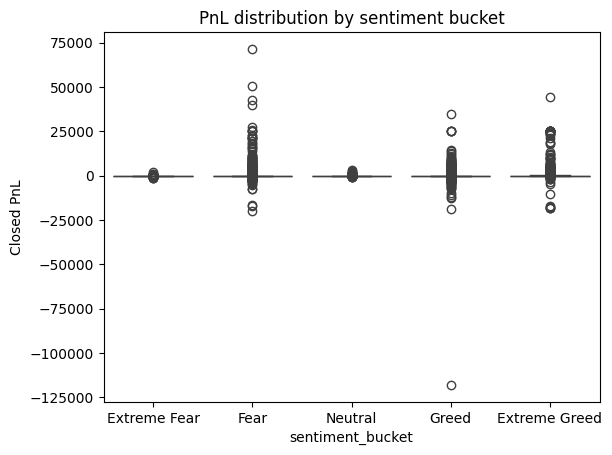

In [26]:
mapping = {
    "Extreme Fear": -2,
    "Fear": -1,
    "Neutral": 0,
    "Greed": 1,
    "Extreme Greed": 2
}
merged['sentiment_score'] = merged['classification'].map(mapping)

df = merged.sort_values("date").reset_index(drop=True)

same_day_corr = df['sentiment_score'].corr(df['Closed PnL'])
print(f"Same-day correlation: {same_day_corr:.4f}")

# 1-day lag 
df['sentiment_lag1'] = df['sentiment_score'].shift(1)
lag1_corr = df['sentiment_lag1'].corr(df['Closed PnL'])
print(f"1-day lead/lag correlation: {lag1_corr:.4f}")

# 2-day lag
df['sentiment_lag2'] = df['sentiment_score'].shift(2)
lag2_corr = df['sentiment_lag2'].corr(df['Closed PnL'])
print(f"2-day lead/lag correlation: {lag2_corr:.4f}")

def sentiment_bucket(score):
    if score <= -2:
        return 'Extreme Fear'
    elif score == -1:
        return 'Fear'
    elif score == 0:
        return 'Neutral'
    elif score == 1:
        return 'Greed'
    elif score >= 2:
        return 'Extreme Greed'

df['sentiment_bucket'] = df['sentiment_score'].apply(sentiment_bucket)

percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
pnl_stats = df.groupby('sentiment_bucket')['Closed PnL'].quantile(percentiles).unstack()
pnl_stats.columns = [f"{int(p*100)}th_pct" for p in percentiles]
print("\nPnL percentiles by sentiment bucket:")
print(pnl_stats)

sns.boxplot(x='sentiment_bucket', y='Closed PnL', data=df, order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title("PnL distribution by sentiment bucket")
plt.ylabel("Closed PnL")
plt.show()



Win rate by market sentiment:
  classification    is_win  win_rate_%
0   Extreme Fear  0.292777   29.277730
1  Extreme Greed  0.553282   55.328233
2           Fear  0.381787   38.178672
3          Greed  0.435707   43.570670
4        Neutral  0.494920   49.492017


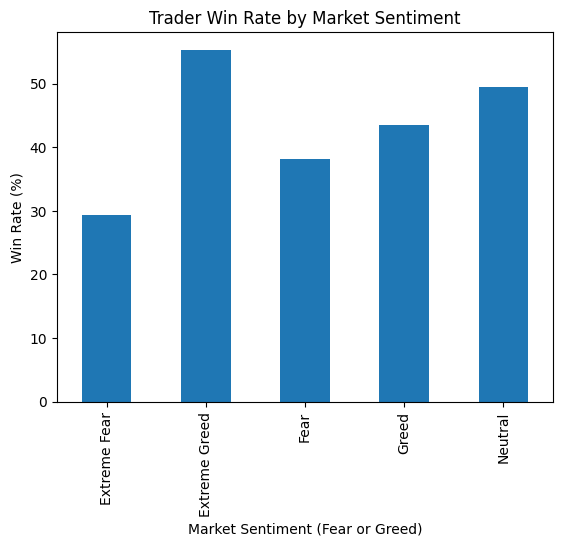

In [14]:
merged['is_win'] = merged['Closed PnL'] > 0

win_rates = merged.groupby('classification')['is_win'].mean().reset_index()

win_rates['win_rate_%'] = win_rates['is_win'] * 100

print("Win rate by market sentiment:")
print(win_rates)

win_rates.plot(x='classification', y='win_rate_%', kind='bar', legend=False)
plt.title('Trader Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment (Fear or Greed)')
plt.show()


Average profit per account under each sentiment:
                                      Account classification  Closed PnL
0  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed    0.000000
1  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  502.539343
2  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed -151.066687
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   Extreme Fear    0.000000
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd           Fear   11.443636

Top 10 accounts during FEAR:
                                        Account classification  Closed PnL
59   0x72c6a4624e1dffa724e6d00d64ceae698af892a0           Fear  996.439069
1    0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  502.539343
107  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3           Fear  388.204726
45   0x4f93fead39b70a1824f981a54d4e55b278e9f760           Fear  137.327338
101  0xb899e522b5715391ae1d4f137653e7906c5e2115           Fear  126.296648
70   0x8170715b3b381dffb7062c0298

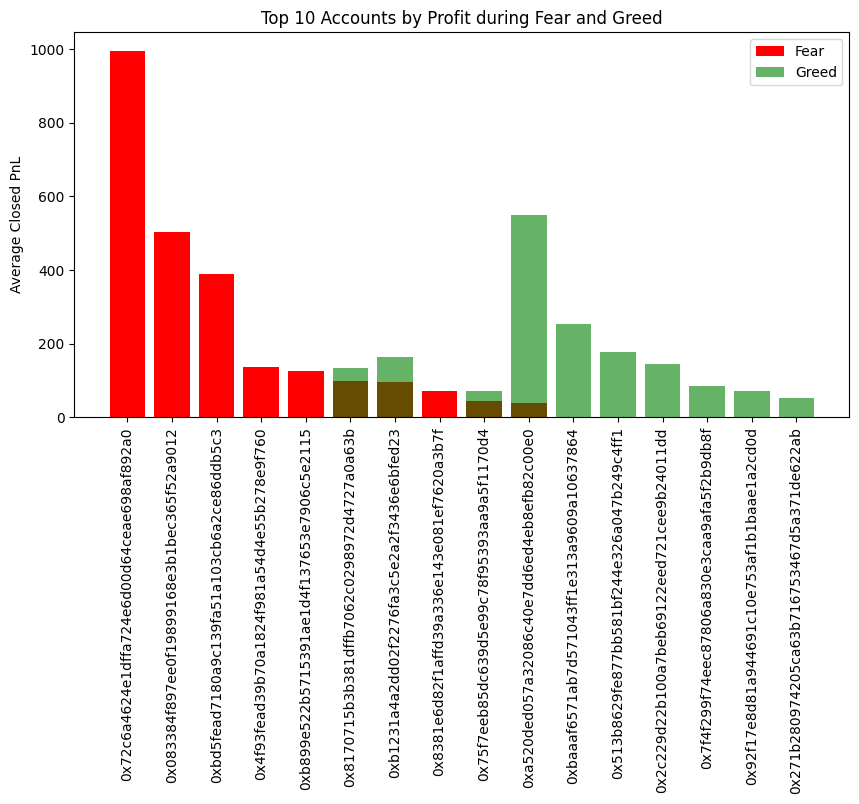

In [16]:
account_perf = merged.groupby(['Account', 'classification'])['Closed PnL'].mean().reset_index()

print("Average profit per account under each sentiment:")
print(account_perf.head())

best_fear = account_perf[account_perf['classification'] == 'Fear'].sort_values(by='Closed PnL', ascending=False).head(10)
best_greed = account_perf[account_perf['classification'] == 'Greed'].sort_values(by='Closed PnL', ascending=False).head(10)

print("\nTop 10 accounts during FEAR:")
print(best_fear)

print("\nTop 10 accounts during GREED:")
print(best_greed)

plt.figure(figsize=(10,5))
plt.bar(best_fear['Account'], best_fear['Closed PnL'], color='red', label='Fear')
plt.bar(best_greed['Account'], best_greed['Closed PnL'], color='green', label='Greed', alpha=0.6)
plt.title('Top 10 Accounts by Profit during Fear and Greed')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=90)
plt.legend()
plt.show()


Average trade size by market sentiment:
  classification   Size Tokens
0   Extreme Fear   2460.043834
1  Extreme Greed  16407.310318
2           Fear   3219.865206
3          Greed  14956.263148
4        Neutral  17720.854908


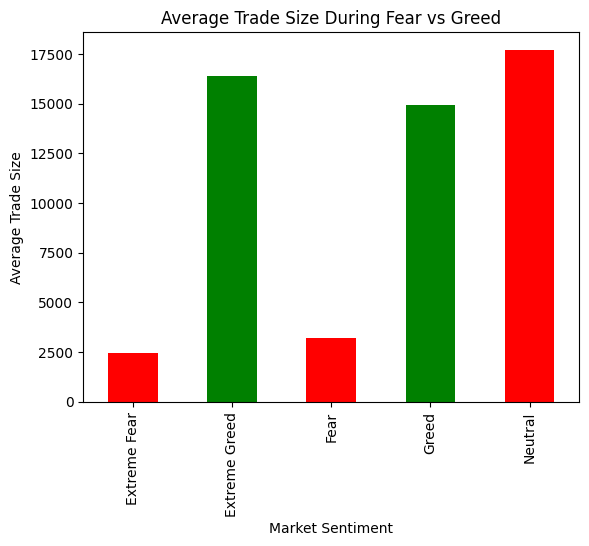

In [19]:
merged['size'] = pd.to_numeric(merged['Size Tokens'], errors='coerce')

size_summary = merged.groupby('classification')['Size Tokens'].mean().reset_index()

print("Average trade size by market sentiment:")
print(size_summary)

size_summary.plot(x='classification', y='Size Tokens', kind='bar', legend=False, color=['red', 'green'])
plt.title('Average Trade Size During Fear vs Greed')
plt.ylabel('Average Trade Size')
plt.xlabel('Market Sentiment')
plt.show()


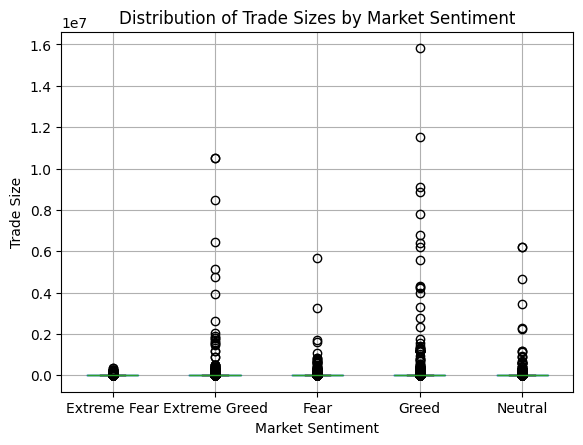

In [20]:
merged.boxplot(column='size', by='classification')
plt.title('Distribution of Trade Sizes by Market Sentiment')
plt.suptitle('')
plt.xlabel('Market Sentiment')
plt.ylabel('Trade Size')
plt.show()
